# Extract Feature from Each Frame

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
feature_scaler = StandardScaler()

# extract features from the CSV file
def extract_frame_features(frame_df, scaler=None):
    num_objects = len(frame_df)
    avg_conf = frame_df["confidence"].mean()
    avg_box_area = ((frame_df["x_max"] - frame_df["x_min"]) *
                    (frame_df["y_max"] - frame_df["y_min"])).mean()

    desired_size = 13
    class_counts = np.zeros(desired_size)

    for cls in frame_df["object_class"]:
        cls = int(cls)
        if cls < desired_size:
            class_counts[cls] += 1

    raw_features = [num_objects, avg_conf, avg_box_area] + class_counts.tolist()
    
    if scaler:
        raw_features = scaler.transform([raw_features])[0]  # normalize
    return torch.tensor(raw_features, dtype=torch.float32)


# Process the CSV file and extract features for each frame
def process_video_csv(csv_path, scaler = None):
    df = pd.read_csv(csv_path)

    sequences = []
    if "frame" not in df.columns or df.empty:
        return torch.empty(0, 16)  # return empty tensor with correct shape

    for _, frame_df in df.groupby("frame"):
        frame_feat = extract_frame_features(frame_df, scaler = scaler)
        sequences.append(frame_feat)

    if not sequences:
        return torch.empty(0, 16)  
    return torch.stack(sequences)




# Load Data Labels

In [3]:
import csv

# Load label CSV into a dictionary
label_dict = {}
with open("../../data/train_labels.csv", newline = "") as f:
    reader = csv.DictReader(f)
    for row in reader:
        label_dict[row["id"]] = int(row["target"])

# Gather all video directories
video_dirs = sorted([
    os.path.join("../../data/yolo_processed_data", d)
    for d in os.listdir("../../data/yolo_processed_data")
    if os.path.isdir(os.path.join("../../data/yolo_processed_data", d))
])

# Split Data into Training, Validation, and Test Sets

In [4]:
# Filter out videos with >75% empty frames
def filter_videos_by_frame_coverage(video_dirs, empty_threshold=0.75):
    filtered = []
    for video_dir in video_dirs:
        csv_path = os.path.join(video_dir, "detections.csv")
        df = pd.read_csv(csv_path)
        # Count total frames via image files
        jpgs = [f for f in os.listdir(video_dir) if f.lower().endswith(".jpg")]
        total_frames = len(jpgs)
        detected_frames = df["frame"].nunique()
        empty_ratio = (total_frames - detected_frames) / total_frames if total_frames > 0 else 1.0
        if empty_ratio <= empty_threshold:
            filtered.append(video_dir)
    return filtered

video_dirs = filter_videos_by_frame_coverage(video_dirs, empty_threshold=0.75)

# Split video IDs
video_ids = [os.path.basename(v).replace("video_", "") for v in video_dirs]
from sklearn.model_selection import train_test_split
train_ids, temp_ids = train_test_split(video_ids, test_size=0.2, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

def get_dirs(ids):
    return [os.path.join("../../data/yolo_processed_data", "video_" + vid) for vid in ids]

train_videos = get_dirs(train_ids)
val_videos   = get_dirs(val_ids)
test_videos  = get_dirs(test_ids)

# Feature scaler
feature_scaler = StandardScaler()
all_train_feats = []
for video_dir in train_videos:
    df = pd.read_csv(os.path.join(video_dir, "detections.csv"))
    for _, frame_df in df.groupby("frame"):
        # extract raw features (no scaler)
        num_objects = len(frame_df)
        avg_conf = frame_df["confidence"].mean()
        avg_box_area = ((frame_df["x_max"]-frame_df["x_min"])*(frame_df["y_max"]-frame_df["y_min"])).mean()
        counts = np.zeros(13)
        for cls in frame_df["object_class"]:
            c = int(cls)
            if c < 13: counts[c] +=1
        feat = [num_objects, avg_conf, avg_box_area] + counts.tolist()
        all_train_feats.append(feat)
feature_scaler.fit(all_train_feats)

StandardScaler()

# Create Dataset and DataLoader

In [5]:
# Video Dataset class
class VideoDataset(Dataset):
    def __init__(self, video_dirs, label_dict, scaler=None):
        self.video_dirs = video_dirs
        self.label_dict = label_dict
        self.scaler = scaler
    def __len__(self): return len(self.video_dirs)
    def __getitem__(self, idx):
        video_dir = self.video_dirs[idx]
        vid = os.path.basename(video_dir).replace("video_", "").zfill(5)
        label = self.label_dict.get(vid, 0)
        df = pd.read_csv(os.path.join(video_dir, "detections.csv"))
        seq = []
        for _, frame_df in df.groupby("frame"):
            # raw features
            num_objects = len(frame_df)
            avg_conf = frame_df["confidence"].mean()
            avg_box_area = ((frame_df["x_max"]-frame_df["x_min"])*(frame_df["y_max"]-frame_df["y_min"])).mean()
            counts = np.zeros(13)
            for cls in frame_df["object_class"]:
                c = int(cls)
                if c < 13: counts[c] +=1
            feat = [num_objects, avg_conf, avg_box_area] + counts.tolist()
            if self.scaler:
                feat = self.scaler.transform([feat])[0]
            seq.append(torch.tensor(feat, dtype=torch.float32))
        if not seq:
            return torch.empty(0,16), torch.tensor(label, dtype=torch.float32)
        return torch.stack(seq), torch.tensor(label, dtype=torch.float32)

# Collate fn 

def collate_fn(batch):
    batch = [(x,y) for x,y in batch if x.size(0)>0]
    if not batch: return None
    batch.sort(key=lambda x: x[0].size(0), reverse=True)
    seqs, labels = zip(*batch)
    lengths = torch.tensor([s.size(0) for s in seqs])
    padded = pad_sequence(seqs, batch_first=True)
    return padded, lengths, torch.stack(labels)

# DataLoaders
train_loader = DataLoader(VideoDataset(train_videos, label_dict, feature_scaler), batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(VideoDataset(val_videos,   label_dict, feature_scaler), batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(VideoDataset(test_videos,  label_dict, feature_scaler), batch_size=4, shuffle=False, collate_fn=collate_fn)

# Define the GRU Model

In [6]:
# Define the GRU model for classification
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, num_layers):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.gru(packed)  
        out = self.fc(hn[-1])     # Get last hidden state
        return self.sigmoid(out).squeeze()



# Training Loop

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, device, epochs, print_epochs=False):
    model.to(device)

    train_losses, val_losses = [], []
    best_val_loss = float("inf")
    patience_counter = 0

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=False)

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in train_loader:
            if batch is None:
                continue

            x_batch, lengths, y_batch = batch
            x_batch, lengths, y_batch = x_batch.to(device), lengths.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch, lengths)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for batch in val_loader:
                if batch is None:
                    continue

                x_batch, lengths, y_batch = batch
                x_batch, lengths, y_batch = x_batch.to(device), lengths.to(device), y_batch.to(device)

                outputs = model(x_batch, lengths)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

                all_preds.extend(outputs.cpu().numpy())
                all_targets.extend(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Scheduler step
        scheduler.step(avg_val_loss)

        # Print info
        if print_epochs:
            print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if print_epochs:
                    print("Early stopping triggered")
                break

    return train_losses, val_losses


# Define the GRU Model

In [10]:
# Define the GRU model for classification
class GRUClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout, num_layers):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, hn = self.gru(packed)  
        out = self.fc(hn[-1])     # Get last hidden state
        return self.sigmoid(out).squeeze()


/opt/anaconda3/envs/testenv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 0.6890, Val Loss: 0.6859
Epoch 2, Train Loss: 0.6794, Val Loss: 0.6793
Epoch 3, Train Loss: 0.6912, Val Loss: 0.6869
Epoch 4, Train Loss: 0.6815, Val Loss: 0.6591
Epoch 5, Train Loss: 0.6787, Val Loss: 0.6759
Epoch 6, Train Loss: 0.6745, Val Loss: 0.6698
Epoch 7, Train Loss: 0.6710, Val Loss: 0.6947
Epoch 8, Train Loss: 0.7082, Val Loss: 0.6982
Epoch 9, Train Loss: 0.6870, Val Loss: 0.6643
Epoch 10, Train Loss: 0.6811, Val Loss: 0.6573
Epoch 11, Train Loss: 0.6714, Val Loss: 0.6554
Epoch 12, Train Loss: 0.6665, Val Loss: 0.6484
Epoch 13, Train Loss: 0.6769, Val Loss: 0.6648
Epoch 14, Train Loss: 0.6806, Val Loss: 0.6652
Epoch 15, Train Loss: 0.6717, Val Loss: 0.6673
Epoch 16, Train Loss: 0.6694, Val Loss: 0.6456
Epoch 17, Train Loss: 0.6594, Val Loss: 0.6339
Epoch 18, Train Loss: 0.6614, Val Loss: 0.6353
Epoch 19, Train Loss: 0.6561, Val Loss: 0.6633
Epoch 20, Train Loss: 0.6546, Val Loss: 0.6495
Epoch 21, Train Loss: 0.6541, Val Loss: 0.6438
Epoch 22, Train Loss: 

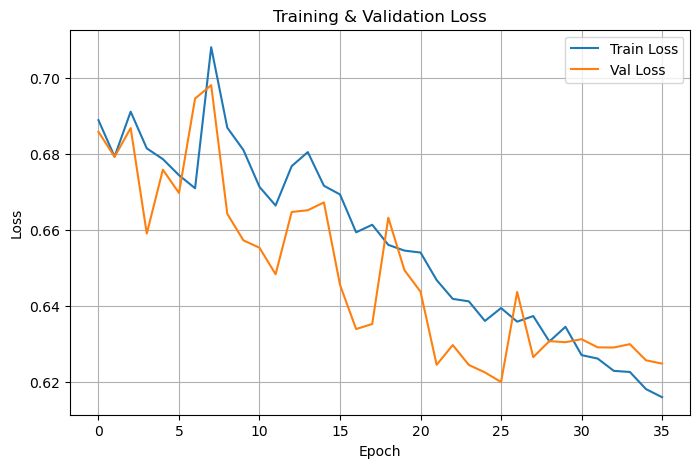

In [35]:
# Main Training & Evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Best so far: hidden_dim = 128, dropout = 0.2, num_layers - 2, lr = 0.001, weight_decay = 0.001

# instantiate model with chosen hyperparameters
model = GRUClassifier(input_dim=16, hidden_dim=256, dropout=0.2, num_layers=2).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Train
train_losses, val_losses = train_model(
    model, train_loader, val_loader,
    criterion, optimizer,
    patience=10, device=device, epochs=50,
    print_epochs=True
)

# Plot losses
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Test Loss: 0.6467, Accuracy: 0.6138
              precision    recall  f1-score   support

No Collision       0.57      0.65      0.61        66
   Collision       0.67      0.58      0.62        79

    accuracy                           0.61       145
   macro avg       0.62      0.62      0.61       145
weighted avg       0.62      0.61      0.61       145



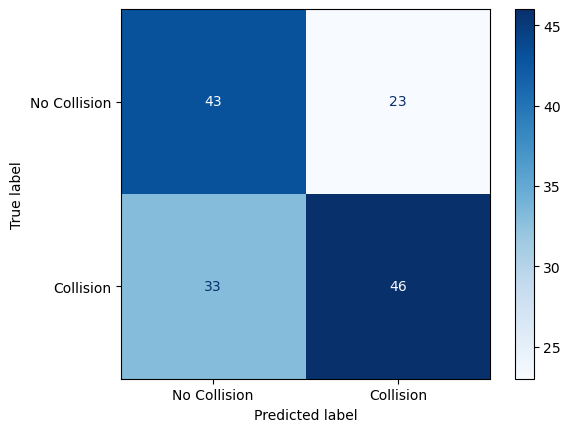

In [36]:
# Evaluate on test data
model.eval()
test_loss=0; correct=0; total=0; preds=[]; labels=[]
with torch.no_grad():
    for batch in test_loader:
        if batch is None: continue
        x,l,y = batch; x,l,y = x.to(device),l.to(device),y.to(device)
        output =model(x,l)
        if output.dim() == 0:
            output = output.unsqueeze(0)
        loss=criterion(output,y); test_loss+=loss.item()
        pred=(output>0.5).float()
        correct += (pred==y).sum().item(); total+=y.size(0)
        preds.extend(pred.cpu().numpy()); labels.extend(y.cpu().numpy())
# metrics
print(f"Test Loss: {test_loss/len(test_loader):.4f}, Accuracy: {correct/total:.4f}")
print(classification_report(labels, preds, target_names=['No Collision','Collision']))
# confusion
cm=confusion_matrix(labels,preds,labels=[0,1])
disp=ConfusionMatrixDisplay(cm,display_labels=['No Collision','Collision'])
disp.plot(cmap=plt.cm.Blues)
plt.show()